In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/machinelearning/meta_optimizer")


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict

from utils.quadratic import Quadratic, Quadratic2D, SimpleQuadratic
from models.rnn_optimizer import MetaLearner, WrapperOptimizee, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.rnn_optimizer import kl_divergence
from models.layer_norm_lstm import LayerNormLSTMCell
from utils.utils import Experiment, get_model, create_def_argparser, get_experiment, create_logger
from utils.plots import loss_plot, param_error_plot, plot_qt_probs
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer

%load_ext autoreload
%autoreload 2

In [2]:
def calc_extra_exp_stats(experiments):
    avg_losses = {"loss": [], "param_error": []}
    for exper in experiments:
        avg_losses["loss"].append(np.mean(exper.val_stats['loss']))
        avg_losses["param_error"].append(np.mean(exper.val_stats['param_error']))
        
    return avg_losses

In [3]:
experiments = []
exper_2 = get_experiment("run_20170405_22_22_58_actV1_40ep_3ops_EVAL")
explogger2 = create_logger(exper_2, file_handler=False)
model_actV1_exper_2 = get_model(exper_2, retrain=True, logger=explogger2)
experiments.append(exper_2)

INFO - INFO - loaded existing model from file logs/run_20170405_22_22_58_actV1_40ep_3ops_EVAL/base_act_3ops.pkl


In [4]:
exper_3 = get_experiment("run_20170405_22_31_36_actV1_40ep_2ops_EVAL")
explogger3 = create_logger(exper_3, file_handler=False)
model_actV1_exper_3 = get_model(exper_3, retrain=True, logger=explogger3)
experiments.append(exper_3)

INFO - INFO - loaded existing model from file logs/run_20170405_22_31_36_actV1_40ep_2ops_EVAL/base_act_2ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170405_22_31_36_actV1_40ep_2ops_EVAL/base_act_2ops.pkl


In [5]:
exper_4 = get_experiment("run_20170405_22_37_34_actV1_40ep_4ops_EVAL")
explogger4 = create_logger(exper_4, file_handler=False)
model_actV1_exper_4 = get_model(exper_4, retrain=True, logger=explogger4)
experiments.append(exper_4)

INFO - INFO - loaded existing model from file logs/run_20170405_22_37_34_actV1_40ep_4ops_EVAL/base_act_4ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170405_22_37_34_actV1_40ep_4ops_EVAL/base_act_4ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170405_22_37_34_actV1_40ep_4ops_EVAL/base_act_4ops.pkl


In [6]:
exper_5 = get_experiment("run_20170405_22_45_35_actV1_40ep_5ops_EVAL")
explogger5 = create_logger(exper_5, file_handler=False)
model_actV1_exper_5 = get_model(exper_5, retrain=True, logger=explogger5)
experiments.append(exper_5)

INFO - INFO - loaded existing model from file logs/run_20170405_22_45_35_actV1_40ep_5ops_EVAL/base_act_5ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170405_22_45_35_actV1_40ep_5ops_EVAL/base_act_5ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170405_22_45_35_actV1_40ep_5ops_EVAL/base_act_5ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170405_22_45_35_actV1_40ep_5ops_EVAL/base_act_5ops.pkl


In [7]:
exper_1 = get_experiment("run_20170405_13_11_28_meta_60ep_10ops_EVAL")
explogger1 = create_logger(exper_1, file_handler=False)
model_actV1_exper_1 = get_model(exper_1, retrain=True, logger=explogger5)
# experiments.append(exper_1)

INFO - INFO - loaded existing model from file logs/run_20170405_13_11_28_meta_60ep_10ops_EVAL/base_meta_10ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170405_13_11_28_meta_60ep_10ops_EVAL/base_meta_10ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170405_13_11_28_meta_60ep_10ops_EVAL/base_meta_10ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170405_13_11_28_meta_60ep_10ops_EVAL/base_meta_10ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170405_13_11_28_meta_60ep_10ops_EVAL/base_meta_10ops.pkl


In [8]:
avg_losses = calc_extra_exp_stats(experiments)

In [9]:
def plot_compare1(experiments, avg_losses, height=8, width=6):
    bar_width = 0.25
    avg_steps = [exper.avg_num_opt_steps for exper in experiments]
    index = avg_steps[:]
    index.sort()
    index = np.array(index)

    plt.figure(figsize=(height, width))
    norm_loss = avg_losses["loss"] * 1/np.sum(avg_losses["loss"])
    plt.bar(avg_steps, norm_loss, bar_width, color='b', 
                 align="center", label="loss")
    plt.bar(np.array(avg_steps)+bar_width, avg_losses["param_error"] * 1/np.sum(avg_losses["param_error"]), 
            bar_width, color='r', align="center",
              label="param-error")
    for i, v in enumerate(norm_loss):
        plt.text(np.array(avg_steps)[i]-bar_width, v + 0.01, 
                 str(np.around(v, decimals=3)), color='blue', fontweight='bold')

    plt.xlabel("Average number of optimization steps")
    plt.ylabel("Normalized avg validation loss/param-error")
    # plt.title("Distribution of optimization steps (E[T|{}]={})".format(config.T, o_mean), **title_font)
    plt.legend(loc="best")
    plt.xticks(index + bar_width / 2, index)
    plt.show

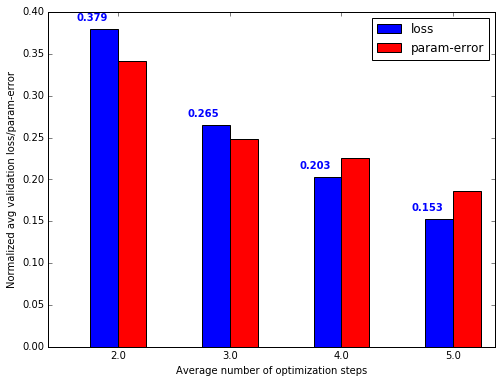

In [10]:
plot_compare1(experiments, avg_losses)

In [132]:
"""
    Create some new validation functions
"""
num_of_val_funcs = 500
val_funcs = [Quadratic2D() for i in range(num_of_val_funcs)]

In [11]:
with open("data/val_funcs_500.dll", 'rb') as f:
    val_funcs = dill.load(f)

In [12]:
new_exper_2 = get_experiment("run_20170405_22_22_58_actV1_40ep_3ops_EVAL")
new_exper_2.val_stats["loss"] = []
new_exper_2.val_stats["param_error"] = []

In [13]:
# new_exper_2.val_stats["step_losses"]
new_exper_2.val_stats["opt_step_hist"]

array([   0.,    0.,  768.,   29.,   78.,   18.,    1.,    6.])

INFO - -----------------------------------------------------------
INFO - -----------------------------------------------------------
INFO - -----------------------------------------------------------
INFO - -----------------------------------------------------------
INFO - -----------------------------------------------------------
INFO - INFO - Epoch 100: Validating meta-learner with 500 functions
INFO - INFO - Epoch 100: Validating meta-learner with 500 functions
INFO - INFO - Epoch 100: Validating meta-learner with 500 functions
INFO - INFO - Epoch 100: Validating meta-learner with 500 functions
INFO - INFO - Epoch 100: Validating meta-learner with 500 functions


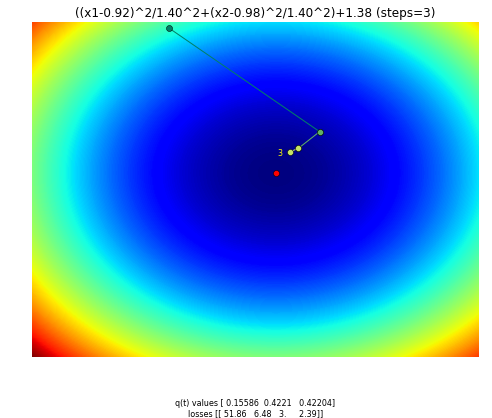

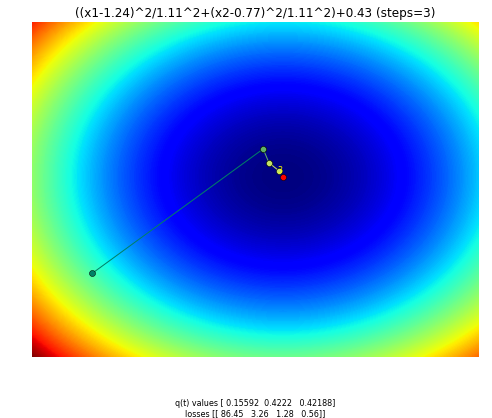

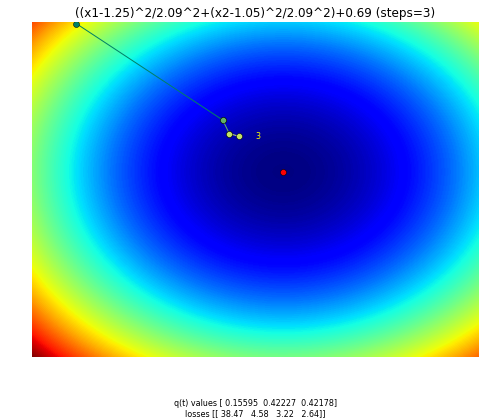

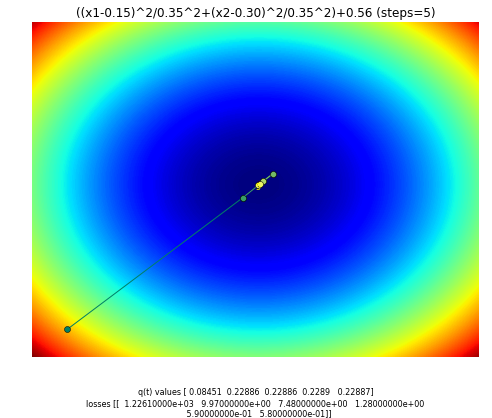

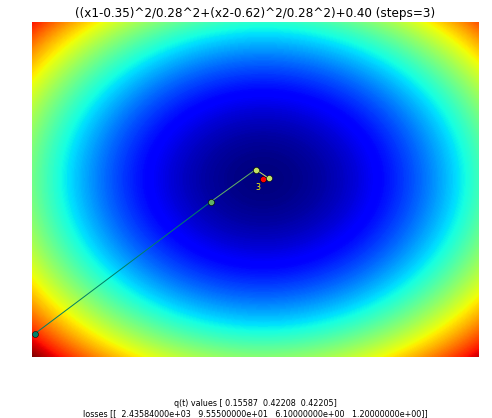

INFO - INFO - Epoch 100: Final validation average loss / param-loss: 2.805/0.4977
INFO - INFO - Epoch 100: Final validation average loss / param-loss: 2.805/0.4977
INFO - INFO - Epoch 100: Final validation average loss / param-loss: 2.805/0.4977
INFO - INFO - Epoch 100: Final validation average loss / param-loss: 2.805/0.4977
INFO - INFO - Epoch 100: Final validation average loss / param-loss: 2.805/0.4977


In [14]:
new_exper_2.epoch = 100
validate_optimizer(model_actV1_exper_2, new_exper_2, explogger2, val_set=val_funcs, 
                   steps=10, verbose=False, plot_func=True, show_plot=True, save_plot=False,
                   num_of_plots=5)

In [15]:
new_exper_5 = get_experiment("run_20170405_22_45_35_actV1_40ep_5ops_EVAL")
new_exper_5.val_stats["loss"] = []
new_exper_5.val_stats["param_error"] = []

INFO - -----------------------------------------------------------
INFO - -----------------------------------------------------------
INFO - -----------------------------------------------------------
INFO - -----------------------------------------------------------
INFO - -----------------------------------------------------------
INFO - INFO - Epoch 100: Validating meta-learner with 500 functions
INFO - INFO - Epoch 100: Validating meta-learner with 500 functions
INFO - INFO - Epoch 100: Validating meta-learner with 500 functions
INFO - INFO - Epoch 100: Validating meta-learner with 500 functions
INFO - INFO - Epoch 100: Validating meta-learner with 500 functions


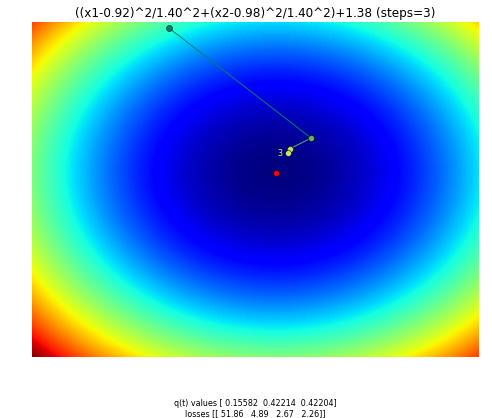

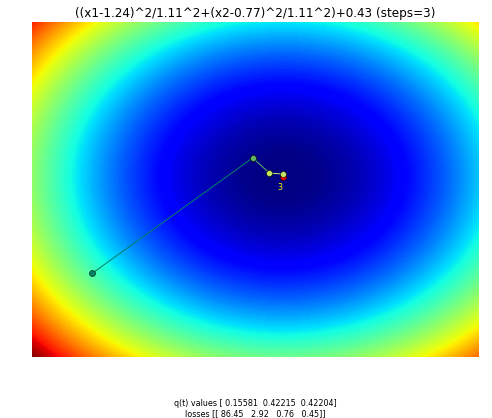

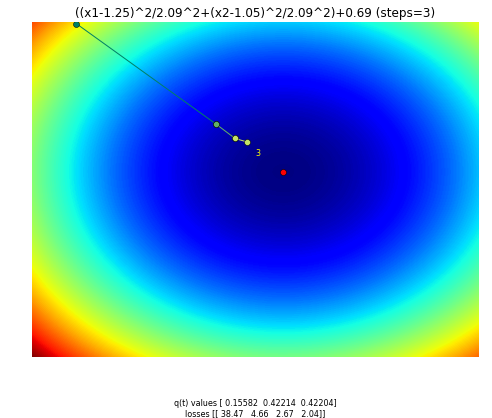

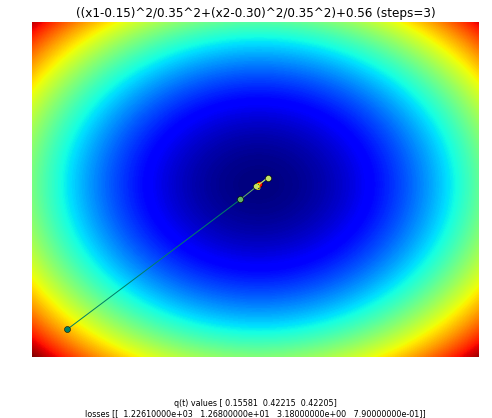

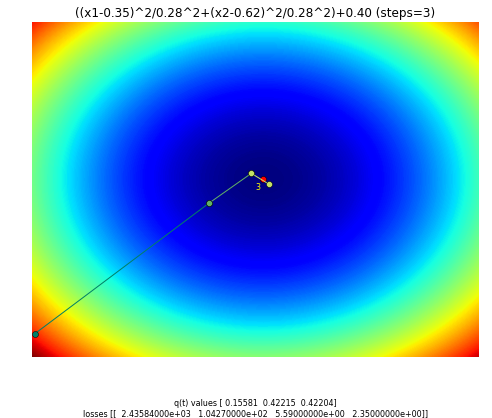

INFO - INFO - Epoch 100: Final validation average loss / param-loss: 2.191/0.4101
INFO - INFO - Epoch 100: Final validation average loss / param-loss: 2.191/0.4101
INFO - INFO - Epoch 100: Final validation average loss / param-loss: 2.191/0.4101
INFO - INFO - Epoch 100: Final validation average loss / param-loss: 2.191/0.4101
INFO - INFO - Epoch 100: Final validation average loss / param-loss: 2.191/0.4101


In [16]:
new_exper_5.epoch = 100
validate_optimizer(model_actV1_exper_5, new_exper_5, explogger5, val_set=val_funcs, 
                   steps=10, verbose=False, plot_func=True, show_plot=True, save_plot=False,
                   num_of_plots=5)

In [17]:
new_exper_3 = get_experiment("run_20170405_22_31_36_actV1_40ep_2ops_EVAL")
new_exper_3.val_stats["loss"] = []
new_exper_3.val_stats["param_error"] = []

INFO - -----------------------------------------------------------
INFO - -----------------------------------------------------------
INFO - -----------------------------------------------------------
INFO - -----------------------------------------------------------
INFO - -----------------------------------------------------------
INFO - INFO - Epoch 100: Validating meta-learner with 500 functions
INFO - INFO - Epoch 100: Validating meta-learner with 500 functions
INFO - INFO - Epoch 100: Validating meta-learner with 500 functions
INFO - INFO - Epoch 100: Validating meta-learner with 500 functions
INFO - INFO - Epoch 100: Validating meta-learner with 500 functions


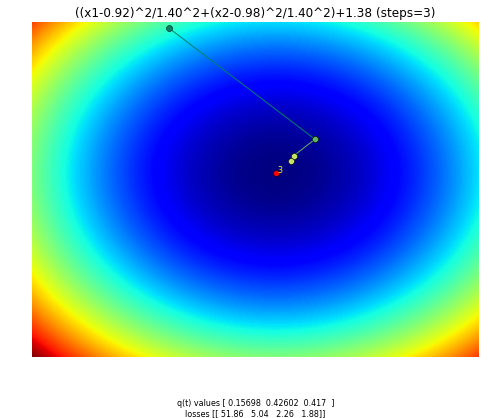

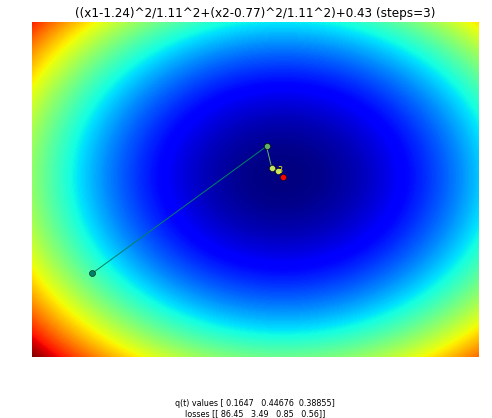

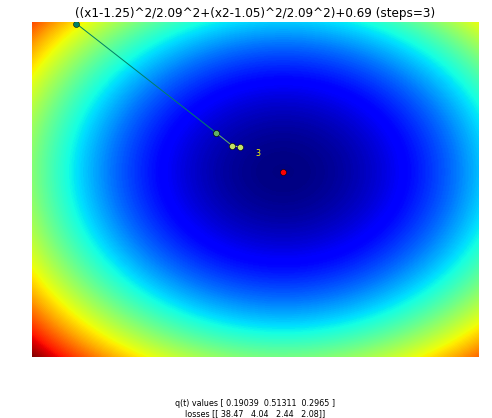

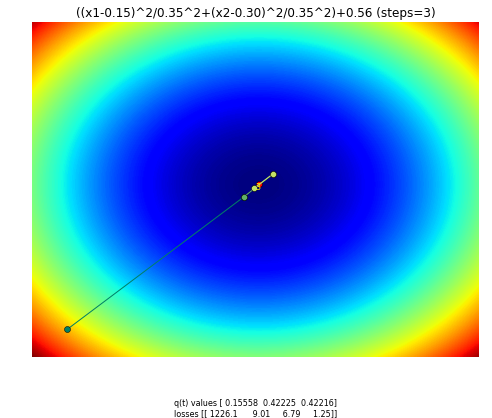

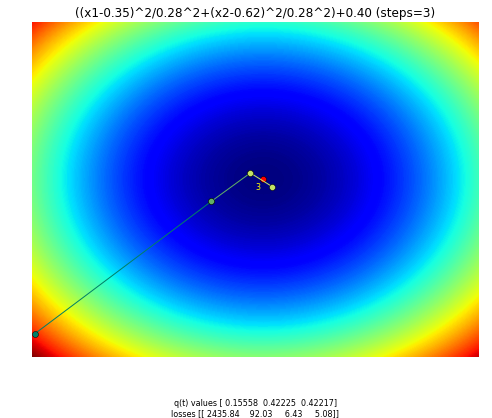

INFO - INFO - Epoch 100: Final validation average loss / param-loss: 2.604/0.4504
INFO - INFO - Epoch 100: Final validation average loss / param-loss: 2.604/0.4504
INFO - INFO - Epoch 100: Final validation average loss / param-loss: 2.604/0.4504
INFO - INFO - Epoch 100: Final validation average loss / param-loss: 2.604/0.4504
INFO - INFO - Epoch 100: Final validation average loss / param-loss: 2.604/0.4504


In [18]:
new_exper_3.epoch = 100
validate_optimizer(model_actV1_exper_3, new_exper_3, explogger3, val_set=val_funcs, 
                   steps=10, verbose=False, plot_func=True, show_plot=True, save_plot=False,
                   num_of_plots=5)

In [21]:
new_exper_1 = get_experiment("run_20170405_13_11_28_meta_60ep_10ops_EVAL")
new_exper_1.val_stats["loss"] = []
new_exper_1.val_stats["param_error"] = []

INFO - -----------------------------------------------------------
INFO - -----------------------------------------------------------
INFO - -----------------------------------------------------------
INFO - -----------------------------------------------------------
INFO - -----------------------------------------------------------
INFO - INFO - Epoch 100: Validating meta-learner with 500 functions
INFO - INFO - Epoch 100: Validating meta-learner with 500 functions
INFO - INFO - Epoch 100: Validating meta-learner with 500 functions
INFO - INFO - Epoch 100: Validating meta-learner with 500 functions
INFO - INFO - Epoch 100: Validating meta-learner with 500 functions


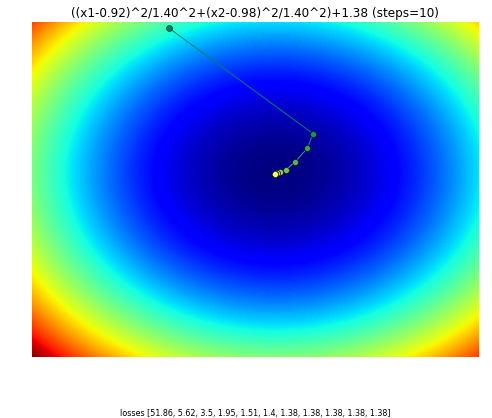

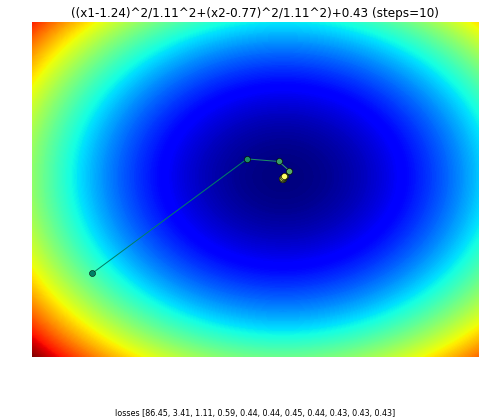

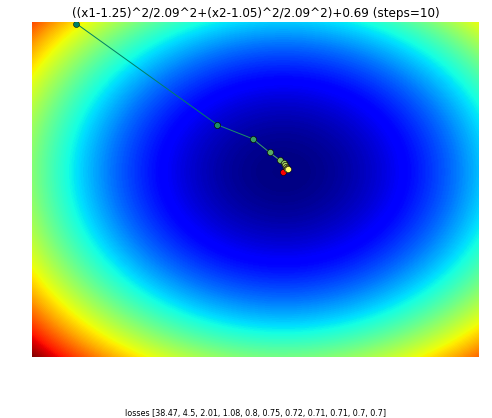

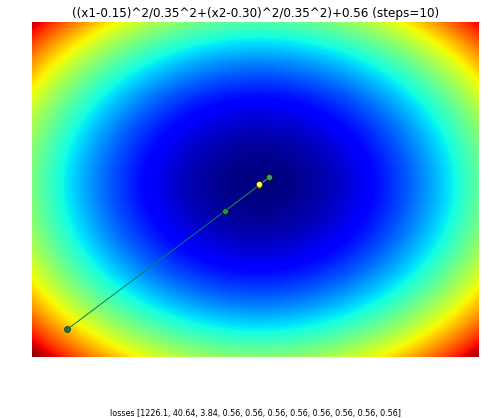

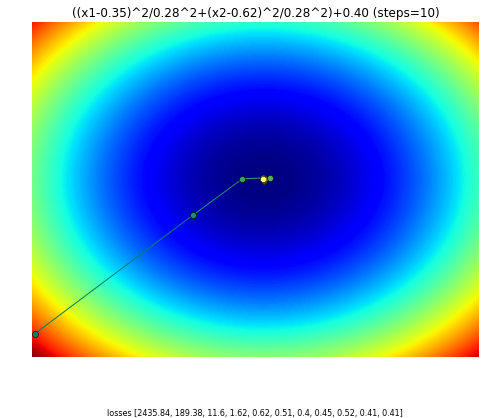

INFO - INFO - Epoch 100: Final validation average loss / param-loss: 0.01209/0.004226
INFO - INFO - Epoch 100: Final validation average loss / param-loss: 0.01209/0.004226
INFO - INFO - Epoch 100: Final validation average loss / param-loss: 0.01209/0.004226
INFO - INFO - Epoch 100: Final validation average loss / param-loss: 0.01209/0.004226
INFO - INFO - Epoch 100: Final validation average loss / param-loss: 0.01209/0.004226


In [22]:
new_exper_1.epoch = 100
validate_optimizer(model_actV1_exper_1, new_exper_1, explogger1, val_set=val_funcs, 
                   steps=10, verbose=False, plot_func=True, show_plot=True, save_plot=False,
                   num_of_plots=5)